Main idea: Fetch multiple datasets of indexes and stocks correlated news to that index. (News only go back one year)
Then we train the model on the multiple datasets and test it on the last dataset.

1. Fetch the stock data from Yahoo Finance
2. Fetch the news data from NewsAPI
3. Preprocess stock data. We will give the model open, close, high, low
4. Preprocess news data to sentiment labels. then backfill the sentiment labels so that there are no missing values
5. Merge the stock data and news data
6. Train the model on the multiple datasets
7. Test the model on the last dataset
8. Evaluate the model
9. Save the model
10. Make predictions

In [160]:
#Data fetching 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from pygooglenews import GoogleNews

In [161]:
#List_of_indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^FTSE', '^N225', '^HSI', '^GDAXI', '^OMX']
List_of_indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^FTSE', '^N225', '^HSI', '^GDAXI', '^OMX', 'XLE', 'AAPL','MSFT','GOOGL','BRK-A','JPM','JNJ','V','WMT','PG','UNH','MA','INTC','VZ','HD','DIS','MRK','KO','PFE','BAC','PEP','CSCO','CMCSA','NFLX','T','ADBE','ABT','XOM','CRM','TMO','ACN','CVX','NKE']

#List_of_indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^FTSE', '^N225', '^HSI', '^GDAXI', '^OMX', '^AORD', '^STOXX50E', '^N225', '^DAX', '^FTSE100', '^MXX', '^SSEC', '^TA35', '^BSESN', '^NSEI', '^SPX', '^VIX', '^NZX50', '^KOSPI', '^BOVESPA', '^TSX', '^NZ50', '^KLSE', '^AS51', '^XAX', '^JSE', '^IBEX','^MIB''^SP500', '^AXJO', '^CAC40', '^AEX', '^MSCI', '^STI', '^SHCOMP', '^KLCI', '^SETI', '^PSEI', '^TASI', '^EGX30', '^OMXS30', '^FTSEALL', '^STOXX600', '^NZX50', '^PWT', '^IBEX35', '^XETRA', '^VIXY', '^EU50', '^MIDCAP', '^DOW']




time_period = '365d'

In [162]:
#Fetch stock data
stock_data = {}
for index in List_of_indexes:
    #Manually create the dataframe
    collected_data = yf.download(index, period ="2y")
    df = pd.DataFrame()
    df['Open'] = collected_data['Open']
    df['Close'] = collected_data['Close']
    df['High'] = collected_data['High']
    df['Low'] = collected_data['Low']
    stock_data[index] = df
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [163]:
#Fetch news data
news_data = {}
gn = GoogleNews()
for index in List_of_indexes:
    news_data[index] = gn.search(index, when='1y')
    print("Fetched news data for: ", index)
    print("Number of articles: ", len(news_data[index]['entries']))
    #Convert to dataframe
    news_data[index] = pd.DataFrame(news_data[index]['entries'])




Fetched news data for:  ^GSPC
Number of articles:  61
Fetched news data for:  ^DJI
Number of articles:  98
Fetched news data for:  ^IXIC
Number of articles:  100
Fetched news data for:  ^RUT
Number of articles:  94
Fetched news data for:  ^FTSE
Number of articles:  99
Fetched news data for:  ^N225
Number of articles:  66
Fetched news data for:  ^HSI
Number of articles:  100
Fetched news data for:  ^GDAXI
Number of articles:  15
Fetched news data for:  ^OMX
Number of articles:  99
Fetched news data for:  XLE
Number of articles:  97
Fetched news data for:  AAPL
Number of articles:  98
Fetched news data for:  MSFT
Number of articles:  98
Fetched news data for:  GOOGL
Number of articles:  98
Fetched news data for:  BRK-A
Number of articles:  82
Fetched news data for:  JPM
Number of articles:  100
Fetched news data for:  JNJ
Number of articles:  99
Fetched news data for:  V
Number of articles:  98
Fetched news data for:  WMT
Number of articles:  98
Fetched news data for:  PG
Number of artic

In [164]:
#Clean up the news data wich contains: title,title_detail,links,link,id,guidislink,published,published_parsed,summary,summary_detail,source,sub_articles
#We will put the title through a sentiment analysis model and then put all none existing values as 0
#Finbert model
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

#Test the model
from transformers import pipeline

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)


news_sentiments = {}

#Add date and sentiment to the dataframe
for index in List_of_indexes:
    news_sentiments[index] = []
    print("Processing news data for: ", index)
    for i in range(len(news_data[index])):
        #print(news_data[index].iloc[i]['title'])
        sentiment = classifier(news_data[index].iloc[i]['title'], top_k=None)
        postive_score = sentiment[0]['score']
        negative_score = sentiment[1]['score']
        neutral_score = sentiment[2]['score']
        #Convert date to dtype='datetime64[ns] so that we can later can merge the dataframes
        reformmated_time_stamp = pd.to_datetime(news_data[index].iloc[i]['published']).date()
        news_sentiments[index] = news_sentiments[index] + [{'Date': reformmated_time_stamp, 'positive_score': postive_score, 'negative_score': negative_score, 'neutral_score': neutral_score}]
    news_sentiments[index] = pd.DataFrame(news_sentiments[index])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0


Processing news data for:  ^GSPC
Processing news data for:  ^DJI
Processing news data for:  ^IXIC
Processing news data for:  ^RUT
Processing news data for:  ^FTSE
Processing news data for:  ^N225
Processing news data for:  ^HSI
Processing news data for:  ^GDAXI
Processing news data for:  ^OMX
Processing news data for:  XLE
Processing news data for:  AAPL
Processing news data for:  MSFT
Processing news data for:  GOOGL
Processing news data for:  BRK-A
Processing news data for:  JPM
Processing news data for:  JNJ
Processing news data for:  V
Processing news data for:  WMT
Processing news data for:  PG
Processing news data for:  UNH
Processing news data for:  MA
Processing news data for:  INTC
Processing news data for:  VZ
Processing news data for:  HD
Processing news data for:  DIS
Processing news data for:  MRK
Processing news data for:  KO
Processing news data for:  PFE
Processing news data for:  BAC
Processing news data for:  PEP
Processing news data for:  CSCO
Processing news data fo

In [165]:
# Average sentiment for days with multiple articles

for index in List_of_indexes:
    # Group by date and calculate mean sentiment scores
    news_sentiments[index] = (
        news_sentiments[index]
        .groupby('Date')
        .mean()
        .fillna(0)  # Handle NaN values
        .reset_index()  # Ensure 'date' becomes a column
        .set_index('Date')  # Set 'date' as the index
        .sort_index()  # Ensure the index is sorted
    )
    
    
# Define a common date range
common_index = pd.date_range(
    start=pd.Timestamp(min(pd.Timestamp(stock_data[index].index.min()), pd.Timestamp(news_sentiments[index].index.min()))),
    end=pd.Timestamp(max(pd.Timestamp(stock_data[index].index.max()), pd.Timestamp(news_sentiments[index].index.max()))),
    freq='D'  # Daily frequency
)

# Reindex both dataframes so they have the same index
stock_data[index] = stock_data[index].reindex(common_index).fillna(-1)  # Fill missing stock data with 0
news_sentiments[index] = news_sentiments[index].reindex(common_index).fillna(0)  # Fill missing sentiment data with 0

# Combine stock data and news sentiment into one DataFrame
combined_data = {}


# Reindex both dataframes

for index in List_of_indexes:
    # Ensure stock_data and news_sentiments have compatible indices
    stock_data[index].index = pd.to_datetime(stock_data[index].index).normalize()  # Normalize index to date only
    news_sentiments[index].index = pd.to_datetime(news_sentiments[index].index).normalize()  # Normalize index to date only
    
    # Merge stock data and news data
    combined_data[index] = pd.merge(
        stock_data[index], 
        news_sentiments[index], 
        how='left', 
        left_index=True, 
        right_index=True
    )
    
    #Drop all close values that are -1
    combined_data[index] = combined_data[index][combined_data[index].Close != -1]
    
    #Fill all missing values with 0
    combined_data[index] = combined_data[index].fillna(0)
    


In [166]:
#Check size of the dataframes
for index in List_of_indexes:
    print("Size of dataframe for ", index, " is: ", combined_data[index].shape)

Size of dataframe for  ^GSPC  is:  (503, 7)
Size of dataframe for  ^DJI  is:  (503, 7)
Size of dataframe for  ^IXIC  is:  (503, 7)
Size of dataframe for  ^RUT  is:  (503, 7)
Size of dataframe for  ^FTSE  is:  (507, 7)
Size of dataframe for  ^N225  is:  (490, 7)
Size of dataframe for  ^HSI  is:  (489, 7)
Size of dataframe for  ^GDAXI  is:  (510, 7)
Size of dataframe for  ^OMX  is:  (503, 7)
Size of dataframe for  XLE  is:  (503, 7)
Size of dataframe for  AAPL  is:  (503, 7)
Size of dataframe for  MSFT  is:  (503, 7)
Size of dataframe for  GOOGL  is:  (503, 7)
Size of dataframe for  BRK-A  is:  (503, 7)
Size of dataframe for  JPM  is:  (503, 7)
Size of dataframe for  JNJ  is:  (503, 7)
Size of dataframe for  V  is:  (503, 7)
Size of dataframe for  WMT  is:  (503, 7)
Size of dataframe for  PG  is:  (503, 7)
Size of dataframe for  UNH  is:  (503, 7)
Size of dataframe for  MA  is:  (503, 7)
Size of dataframe for  INTC  is:  (503, 7)
Size of dataframe for  VZ  is:  (503, 7)
Size of dataframe

In [167]:
#Reformat the dataframes to be able to train the model
#We will use the last 30 days as testa data and the rest as training data as the data comes from diffrent indexes
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


def create_sequences(input_data, output_data, timesteps, output_dim):
    xs, ys = [], []
    for i in range(len(input_data) - output_dim - timesteps):
        x = input_data[i:(i + timesteps)]
        y = output_data[i + timesteps:i + output_dim + timesteps]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

timesteps = 30
input_dim = 7
output_dim = 5 #Predict 5 days ahead


# Initialize global scalers
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

# Gather all data for global scaling
xs = []
ys = []
for index in List_of_indexes: 
    data = combined_data[index]
    # Normalize data
    input_features = data[['Open', 'Close', 'High', 'Low', 'positive_score', 'negative_score', 'neutral_score']].values
    output_feature = data[['Close']].values
    scaler = MinMaxScaler()
    input_features_scaled = scaler.fit_transform(input_features)
    output_feature_scaled = scaler.fit_transform(output_feature)
    
    # Create sequences
    x, y = create_sequences(input_features_scaled, output_feature_scaled, timesteps, output_dim)
    xs.append(x)
    ys.append(y)
    
# Concatenate all sequences
xs = np.concatenate(xs)
ys = np.concatenate(ys)

print(xs.shape, ys.shape)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, shuffle=False)

print(xs.shape, ys.shape)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.1, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)


(19640, 30, 7) (19640, 5, 1)
(19640, 30, 7) (19640, 5, 1)


In [168]:
model = Sequential() 
model.add(LSTM(256, input_shape=(timesteps, input_dim)))

model.add(Dense(output_dim))


model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])


2025-01-06 07:17:14,927 WARNING: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

Epoch 1/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0149 - val_loss: 0.0058
Epoch 2/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 3/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 4/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 5/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 6/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 7/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 8/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 9/100
442/442 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - loss: 0.0028 

In [169]:
#Evaluate the model
test_results = model.evaluate(x_test, y_test)
test_loss = test_results
print(f'Test Loss: {test_loss}')

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037
Test Loss: 0.003984019625931978


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


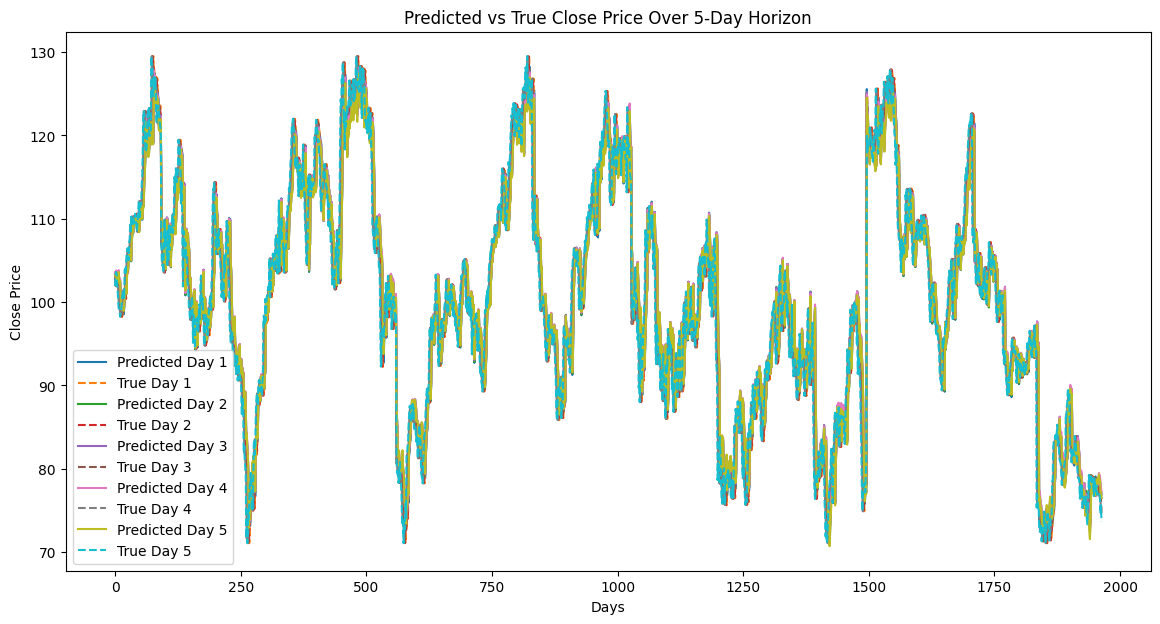

In [170]:
# Make predictions
predictions = model.predict(x_test)

# Reshape y_test from (390, 5, 1) to (390, 5)
y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1])

# Inverse transform predictions and y_test
predictions_unscaled = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test_reshaped)

# Plot predictions vs. true values
plt.figure(figsize=(14, 7))

# Plot for each of the 5 prediction days
for i in range(5):  # 5 prediction steps
    plt.plot(
        range(len(predictions_unscaled[:, i])),
        predictions_unscaled[:, i],
        label=f'Predicted Day {i + 1}',
    )
    plt.plot(
        range(len(y_test_unscaled[:, i])),
        y_test_unscaled[:, i],
        linestyle='--',
        label=f'True Day {i + 1}',
    )

plt.ylabel('Close Price')
plt.xlabel('Days')
plt.title('Predicted vs True Close Price Over 5-Day Horizon')
plt.legend()
plt.show()


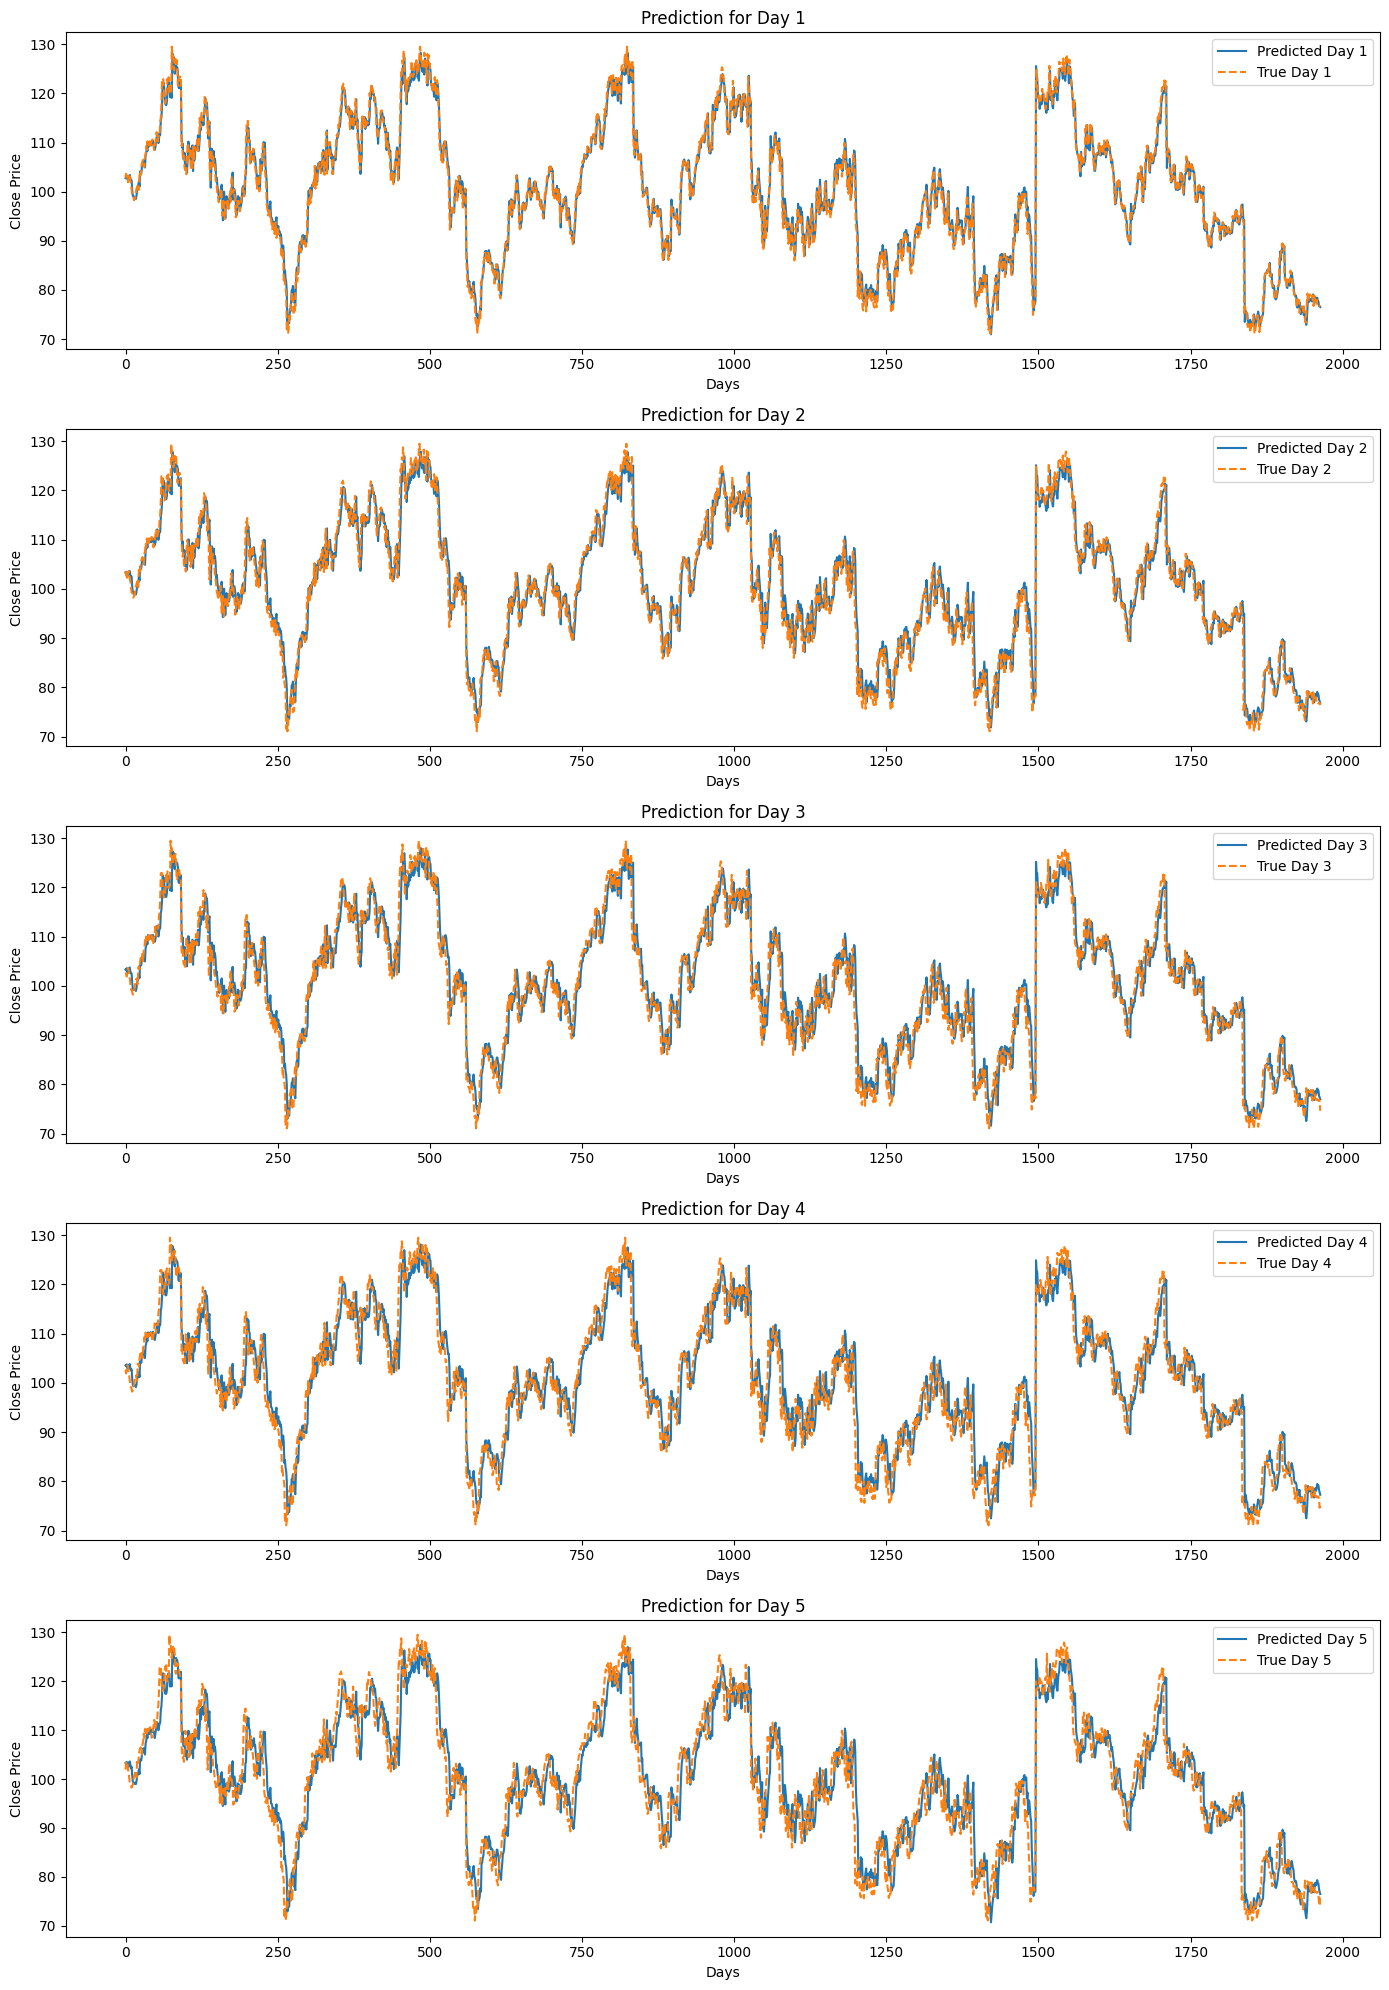

In [171]:
# Plot predictions and true values in separate subplots
plt.figure(figsize=(14, 20))

for i in range(5):  # 5 prediction steps
    plt.subplot(5, 1, i + 1)  # Create 5 subplots, one for each prediction day
    plt.plot(
        range(len(predictions_unscaled[:, i])),
        predictions_unscaled[:, i],
        label=f'Predicted Day {i + 1}',
    )
    plt.plot(
        range(len(y_test_unscaled[:, i])),
        y_test_unscaled[:, i],
        linestyle='--',
        label=f'True Day {i + 1}',
    )
    plt.ylabel('Close Price')
    plt.xlabel('Days')
    plt.title(f'Prediction for Day {i + 1}')
    plt.legend()

plt.tight_layout()
plt.show()


In [172]:
#Save the model to hopsworks
import hopsworks
import os
import warnings
from hsml.schema import Schema
from hsml.model_schema import ModelSchema


In [173]:
with open('./project_api_key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
    print("API Key is set")
    print("First 5 characters of API Key: ", os.environ["HOPSWORKS_API_KEY"][:5])

API Key is set
First 5 characters of API Key:  pwWjy


In [174]:
model_dir = "FinanceModel"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [175]:
#Get loss of model 


In [177]:
project = hopsworks.login() 

model_dir = "Resources/Models"

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(x_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()
model.save(model_dir + "/model.keras") 

#Save the scalers as well
import joblib

joblib.dump(scaler, model_dir + "/scaler.pkl") 


mr = project.get_model_registry()

#Get model metrics

res_dict = {
    "MSE" : test_loss
}

aq_model = mr.python.create_model(
    name="FinanceModel", 
    metrics= res_dict,
    model_schema=model_schema,
    description="Predicting stock prices using LSTM model trained on multiple indexes.",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)


2025-01-06 07:22:22,192 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-06 07:22:22,195 INFO: Initializing external client
2025-01-06 07:22:22,195 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-06 07:22:23,462 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1168540


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/725 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3283612 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/725 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/863608 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/965 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/224 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1168540/models/FinanceModel/8


Model(name: 'FinanceModel', version: 8)